'''
https://github.com/nbhr/pycalib/blob/master/ipynb/incalib_charuco.ipynb
'''

# Intrinsic Camera Calibration of GoPro with OpenCV ChAruCo pattern

### Goal

The goal of this notebook is to calibrate the intrinsic parameter $K$ of the camera.  Given a number of chessboard (charuco) images, this notebook first detects the corner positions in each image, and then finds the camera pose of each frame and the camera intrinsic parameters.

* Input:  $n$ chessboard images (= the 2D corner position $x$ and the corresponding 3D position $X$ in the world (chessboard) coordinate system)
* Output: intrinsic parameter $K$, distortion coefficients $d$, $n$ camera poses $R_i, t_i$ w.r.t. the chessboard

To have a better / robust estimation of $K$, the chessboard should be captured as large as possible in the DoF in different poses.


Notice:
* The chessboard coordinate system serves as the world coordinate system.
* Though we obtain $R, t$ as a result, we are not interested in them in this scenario.


### Projection model

Please check the OpenCV document for the detail. 
* https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#details

In short, a 3D point $X$ in the world coordinate system (WCS) is transformed to the camera coordinate system (CCS) by a roation $R$ and a translation $t$, and then projected to $x$ by $K$:
\begin{equation}
\tilde{x} \sim K \begin{bmatrix}
R \: | \: t
\end{bmatrix}
\tilde{X}.
\end{equation}


## Libraries

In [1]:
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Calibration parameters

**Important**
* Compare the pattern shown below with the pattern captured in the image.
* The numbers of rows and cols indicate **the numbers of CELLs, not corners**.
  * For example, an 18x9 ChAruco board has a 18 cells == 17 corners by 9 cells == 8 corners pattern.
  * In the case of the traditional chessboard, the rows and cols indicate the numbers of corners.

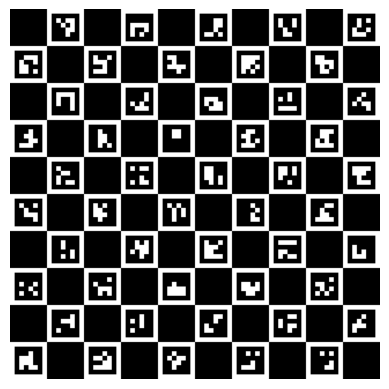

In [2]:
# Chessboard configuration
num_charuco_squares = 10
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
board = cv2.aruco.CharucoBoard((num_charuco_squares, num_charuco_squares), 0.02, 0.015, aruco_dict)

# check if the board is correct
image = board.generateImage((2560, 2560))

# (Optional) save the image to "aruco_calib.jpg"
save_aruco_image = False
if save_aruco_image:
    print("Saving aruco_calib.jpg")
    cv2.imwrite("aruco_calib.jpg", image)

plt.figure()
plt.imshow(image, cmap='gray')
#plt.title('DICT_4X4_250 6x5 ChAruco pattern')
plt.axis('off')
plt.show()

In [3]:
from rel.cameras.orbbec import Orbbec
from rel.cameras.realsense import Realsense
from rel import CAMERA_DATA_PATH

# 0. set your hyperparameters
serial_number = 'CL8H74100BB'
camera_type = "orbbec"
save_dir_path = CAMERA_DATA_PATH / serial_number / "0427_intrinsics"
save_dir_path.mkdir(parents=True, exist_ok=True)


# 1. setup camera
if camera_type == "orbbec":
    camera = Orbbec(serial_number, use_color=True, use_depth=False)
elif camera_type == "realsense":
    camera = Realsense(serial_number)
else:
    raise ValueError
    

def create_window_and_capture_data(camera, save_dir='captured_images'):
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    index = 0  # Initialize the index for saved images
    while True:
        # Get the current data from the Realsense instance
        rt_dict = camera.getCurrentData(pointcloud=False)
        rgb_image = rt_dict['rgb']
        # Display the RGB and colored depth images
        cv2.imshow('Color Image', cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR))
        # Wait for a key press
        key = cv2.waitKey(1) & 0xFF
        # If the space bar is pressed, save the images
        if key == ord(' '):
            color_filename = os.path.join(save_dir, f"{index:05d}_color.jpg")
            # Save the color and depth images
            cv2.imwrite(color_filename, cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR))
            index += 1
        # Exit on 'q' key press
        elif key == ord('q'):
            break

    # Close all OpenCV windows
    cv2.destroyAllWindows()
    camera.stop()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[04/27 09:54:26.568367][info][42614][Context.cpp:68] Context created with config: default config!
[04/27 09:54:26.568372][info][42614][Context.cpp:73] Work directory=/home/rpt/rpt/rwVR/rel/calib, SDK version=v1.10.16-20241021-5113dad
[04/27 09:54:26.568379][info][42614][LinuxPal.cpp:32] createObPal: create LinuxPal!
[04/27 09:54:26.570151][info][42614][LinuxPal.cpp:166] Create PollingDeviceWatcher!
[04/27 09:54:26.570159][info][42614][DeviceManager.cpp:15] Current found device(s): (1)
[04/27 09:54:26.570161][info][42614][DeviceManager.cpp:24] 	- Name: Femto Bolt, PID: 0x066b, SN/ID: CL8H74100BB, Connection: USB3.1
[04/27 09:54:26.570163][info][42614][Pipeline.cpp:15] Try to create pipeline with default device.
[04/27 09:54:26.570177][info][42614][FemtoBoltUvcDevice.cpp:23] FemtoBoltUvcDevice init ...
[04/27 09:54:26.570

In [4]:
create_window_and_capture_data(camera, save_dir=str(save_dir_path))

[04/27 09:54:38.354051][warning][42826][Pipeline.cpp:341] Pipeline source frameset queue fulled, drop the oldest frame! [**66 logs in 6067ms, last: 09:54:36.668583**]
[04/27 09:54:46.733728][warning][42614][Pipeline.cpp:377] Wait for frame timeout, you can try to increase the wait time! current timeout=100
[04/27 09:55:01.871285][warning][42614][Pipeline.cpp:377] Wait for frame timeout, you can try to increase the wait time! current timeout=100
[04/27 09:55:17.075797][warning][42614][Pipeline.cpp:377] Wait for frame timeout, you can try to increase the wait time! current timeout=100
[04/27 09:55:32.211589][warning][42614][Pipeline.cpp:377] Wait for frame timeout, you can try to increase the wait time! current timeout=100
[04/27 09:55:47.415015][warning][42614][Pipeline.cpp:377] Wait for frame timeout, you can try to increase the wait time! current timeout=100
[04/27 09:56:02.555103][warning][42614][Pipeline.cpp:377] Wait for frame timeout, you can try to increase the wait time! current

## 2D corner detection

In [5]:
# Input images capturing the chessboard above
input_files = glob(os.path.join(str(save_dir_path), '*.jpg'))
input_files.sort()
input_files

['/home/rpt/rpt/rwVR/data/cameras/CL8H74100BB/0427_intrinsics/00000_color.jpg',
 '/home/rpt/rpt/rwVR/data/cameras/CL8H74100BB/0427_intrinsics/00001_color.jpg',
 '/home/rpt/rpt/rwVR/data/cameras/CL8H74100BB/0427_intrinsics/00002_color.jpg',
 '/home/rpt/rpt/rwVR/data/cameras/CL8H74100BB/0427_intrinsics/00003_color.jpg',
 '/home/rpt/rpt/rwVR/data/cameras/CL8H74100BB/0427_intrinsics/00004_color.jpg',
 '/home/rpt/rpt/rwVR/data/cameras/CL8H74100BB/0427_intrinsics/00005_color.jpg',
 '/home/rpt/rpt/rwVR/data/cameras/CL8H74100BB/0427_intrinsics/00006_color.jpg',
 '/home/rpt/rpt/rwVR/data/cameras/CL8H74100BB/0427_intrinsics/00007_color.jpg',
 '/home/rpt/rpt/rwVR/data/cameras/CL8H74100BB/0427_intrinsics/00008_color.jpg',
 '/home/rpt/rpt/rwVR/data/cameras/CL8H74100BB/0427_intrinsics/00009_color.jpg',
 '/home/rpt/rpt/rwVR/data/cameras/CL8H74100BB/0427_intrinsics/00010_color.jpg',
 '/home/rpt/rpt/rwVR/data/cameras/CL8H74100BB/0427_intrinsics/00011_color.jpg',
 '/home/rpt/rpt/rwVR/data/cameras/CL8H74

In [6]:
parameters =  cv2.aruco.DetectorParameters()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_CONTOUR
detector = cv2.aruco.CharucoDetector(board, detectorParams=parameters)

all_obj_pts = []
all_img_pts = []
all_ids = []

for i in input_files:
    frame = cv2.imread(i)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    c_corners, c_ids, corners, ids = detector.detectBoard(gray)
    if c_corners is not None and len(c_corners) > 0:
        objPoints, imgPoints = board.matchImagePoints(c_corners, c_ids)
        if objPoints.shape[0] != (num_charuco_squares - 1) ** 2:
            continue
        all_obj_pts.append(objPoints)
        all_img_pts.append(imgPoints)
        all_ids.append(c_ids)

    imsize = (gray.shape[1], gray.shape[0])

all_obj_pts = np.array(all_obj_pts)
all_img_pts = np.array(all_img_pts)

print(all_obj_pts.shape, all_img_pts.shape)


(19, 81, 1, 3) (19, 81, 1, 2)


## Calibration

In [8]:
from rel import CAMERA_ASSETS_PATH

ret, K, d, rvec, tvec = cv2.calibrateCamera(all_obj_pts, all_img_pts, imsize, None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_RATIONAL_MODEL)

# save K 
save_camera_intr_path = CAMERA_ASSETS_PATH / serial_number 
save_camera_intr_path.mkdir(parents=True, exist_ok=True)
save_K_path = CAMERA_ASSETS_PATH / serial_number / "K.npy"
save_d_path = CAMERA_ASSETS_PATH / serial_number / "d.npy"
np.save(save_K_path, K)
np.save(save_d_path, d)

print("Image size = ", imsize)
print("Reprojection error = ", ret)
print("Intrinsic parameter K = ", K)
print("Distortion parameters d = (k1, k2, p1, p2, k3, k4, k5, k6) = ", d)

assert ret < 1.0

Image size =  (1920, 1080)
Reprojection error =  0.24597638912356568
Intrinsic parameter K =  [[1.16450437e+03 0.00000000e+00 9.23019594e+02]
 [0.00000000e+00 1.16450437e+03 5.33786069e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion parameters d = (k1, k2, p1, p2, k3, k4, k5, k6) =  [[-9.10153048e+00  4.12547573e+01 -2.12290376e-03 -9.98831705e-03
   1.43988736e+02 -9.20482632e+00  4.24218039e+01  1.36527007e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [9]:
original_camera_matrix = camera.K
original_camera_matrix

array([[1.12546045e+03, 0.00000000e+00, 9.56526367e+02],
       [0.00000000e+00, 1.12444824e+03, 5.42040466e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])